In [49]:
# Notebook to view all the rasters and the waveforms associated to a stimulus
# Example on how to dig into a .kwik file
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py

matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    sys.path.append('/Users/zeke/repos/ephysflow')
    sys.path.append('/Users/zeke/repos/soundflow/sound_tools')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

if 'lintu' in comp_name or 'passaro' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    sys.path.append('/mnt/cube/earneodo/repos/ephysflow')
    repos_folder=os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')
tejaswy_data_folder = os.path.join(experiment_folder, 'export_data', 'tesajwy', )

sys.path.append(os.path.join(repos_folder, 'swissknife'))


#file structure
bird_id = 'z003'
sess = 1
rec = 'a'
run = 1
sess_name = 'S001_Pen03_Lft_AP500_ML500__Site01_Z2000__z003_cat_P03_S01_1_02'

raw_file_folder = os.path.join(raw_data_folder, bird_id, str(sess).zfill(3))
raw_file_name = rec + '_' + str(run).zfill(2) + '_song.wav'
raw_file_path = os.path.join(raw_file_folder, raw_file_name)
ss_file_folder =os.path.join(ss_data_folder, bird_id, 'with_stims', sess_name)
kwik_files = [f for f in os.listdir(ss_file_folder) if f.endswith('.kwik')]
kwik_file = kwik_files[0]
print kwik_file
# open the file in read mode
kwik_file = h5py.File(os.path.join(ss_file_folder, kwik_file), 'r')   

Computer: passaro
z003_cat_P03_S01_1.kwik


In [2]:
# functions to browse through the stims and units
from phy_tools import kwik_functions as kwf

# List all the wave stimuli in the file
all_stim_names = kwf.list_sound_stimuli(kwik_file)
print "stimulus names"
print all_stim_names
print ""

# list all the sorted units
all_units = kwf.list_units(kwik_file)
# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print all_units['clu']

stimulus names
['sound_001_40000' 'sound_002_40000' 'sound_003_40000' 'sound_004_40000'
 'sound_005_40000' 'sound_006_40000']

[14 16 22  4 44 63 64 66 69 71 73 75 76 77 78 79]


Stamps of this event occurrences
[ 4439197  5218363  5757565  8449165  9861725 11417909 11588743 11969803
 12299473 12839371 18596559 19320673 19522251 20310191 20857477 21081591
 22036515 24585563 24805323 26361127 27350331 27831391 28416237 28960933
 30095339 30634605 31120779 32226395 38612747 39428151]

Sampling rate (Hz): 31250.0
Metadata
{'stim': {u'sampling_rate': 40000.0}, 'stream': {}}
{u'sampling_rate': 40000.0}


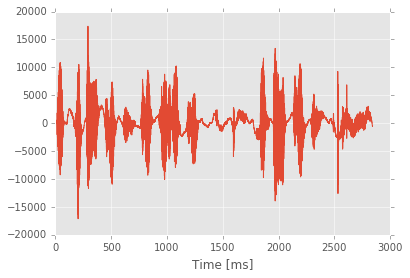

In [3]:
# get one of the stimuli:
from basic_viewing.events import Event, Sound
# creating a stimulus object with that name will refer to the data of it in the kwik file
stim = Sound('sound_001_40000', h5=kwik_file)

# some queries on the stimulus:
# stamps in the recording where the event started:
print "Stamps of this event occurrences"
print stim.start
# sampling frequency of the recording (i.e, of the recording)
print ""
print "Sampling rate (Hz): " + str(stim.sampling_rate)

# get the actual waveform of the stimulus as it was played and its metadata:
waveform, meta = stim.get_waveform()
waveform = waveform.astype('float') # convert int16 to float
# meta is a dictionary with metadata:
# sampling_rate: sampling rate of the waveform (independent from recording)
# synt: whether it is synthetic song or not
# type: birds own song (bos), (con)specific, (rev)ersed bos, etc..
print "Metadata"
print meta #note that there is metadata for the stimulus and for the stream
print meta['stim']
t = np.arange(0,len(waveform))/stim.sampling_rate*1000
plt.plot(t,waveform)
plt.xlabel('Time [ms]')

In [33]:
all_units.shape

(16,)

In [47]:
s_f

31250.0

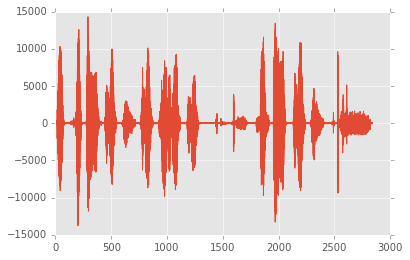

In [51]:
from streamtools import spectral as sp
filter_pars = sp.make_butter_bandpass(s_f, 400, 10000)
waveform = sp.apply_butter_bandpass(waveform, filter_pars)
plt.plot(t, waveform)

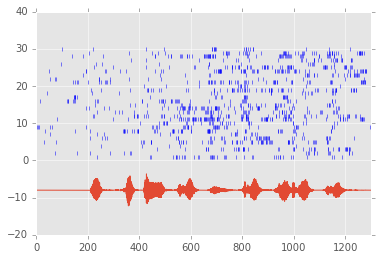

In [93]:
# get one of the units:
from basic_viewing.units import Unit

one_unit = all_units[9]
one_unit_clu = one_unit['clu']

# instance a Unit object
unit = Unit(one_unit_clu, kwik_file=kwik_file)
# get the spike times (in sample units)
unit.get_time_stamps()
# get the sampling rate of the recording
s_f = unit.sampling_rate

#get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
before_ms = 200
after_ms = 1100
start_points = stim.start - np.int(s_f * before_ms/1000.) #start_points has to be in sample units

rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
# the raster is an n_trial * m array (where m can be sample or ms).
# in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial

# plot the raster
from basic_viewing import basic_plot as bp
b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
plt.scatter(rs, b, marker='|')
plt.xlim(0, before_ms + after_ms)

# plot the waveform underneath the raster
span_before = np.zeros(np.int(before_ms/1000. * meta['stim']['sampling_rate']))
#span_before[:] = np.nan
span_after = np.zeros(np.int(after_ms/1000. * meta['stim']['sampling_rate']))
waveform_pre_plot = np.insert(waveform, 0, span_before)
#waveform_plot = np.insert(span_after, 0, waveform_plot)
span = span_before.shape[0]+span_after.shape[0]
waveform_plot=waveform_pre_plot[:span]
waveform_t_plot = np.arange(waveform_plot.size)*1000./meta['stim']['sampling_rate']
plt.plot(waveform_t_plot, (waveform_plot/32768.-0.8)*10)

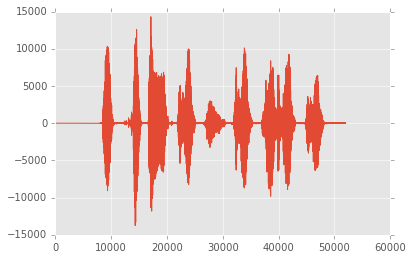

In [94]:
plt.plot(waveform_plot)

In [87]:
waveform.shape

(88773,)

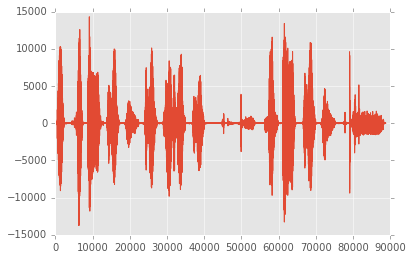

In [86]:
plt.plot(waveform)

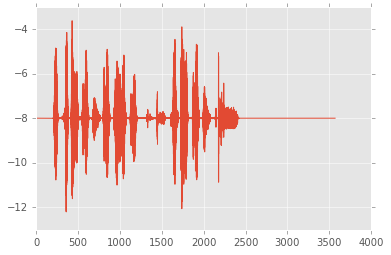

In [72]:
plt.plot(waveform_t_plot, (waveform_plot/32768.-0.8)*10)

(array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 <matplotlib.axes._axes.Axes at 0x7fe220e818d0>)

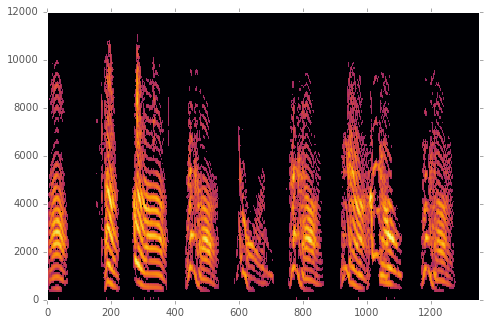

In [81]:
plot_spectrogram(waveform, 0, 1350, 31250, n_window = 512, n_overlap=512-1, scaling='spectrum')

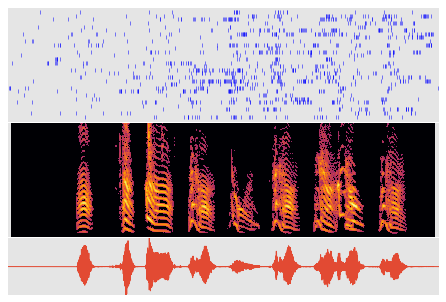

In [110]:
fig_ax={}
fig = plt.figure()
fig_ax['raster'] = fig.add_axes([0,.6,1,0.4])
      
fig_ax['spectrogram'] = fig.add_axes([0,0.2,1,0.4])
fig_ax['waveform'] = fig.add_axes([0,0,1,0.2]) 

for ax in fig_ax.itervalues():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlim([0, before_ms + after_ms])

fig_ax['waveform'].plot(waveform_t_plot, 
                        (waveform_plot/32768.-0.8)*10)
spectr, fig_ax['spectrogram'] = plot_spectrogram(waveform_plot, 0, 1300, 40000, 
                 n_window = 1024, n_overlap=1024-1, scaling='spectrum', ax=fig_ax['spectrogram'])
fig_ax['raster'].scatter(rs, b, marker='|')



In [104]:
fig_fname = os.path.join(ss_file_folder, 'rasters_{}.eps'.format(one_unit_clu))
fig.savefig(fig_fname, format='eps', dpi=100)
print fig_fname

/mnt/cube/earneodo/bci_zf/ss_data/z003/with_stims/S001_Pen03_Lft_AP500_ML500__Site01_Z2000__z003_cat_P03_S01_1_02/rasters_71.eps


In [109]:
from scipy.signal import spectrogram

def plot_spectrogram(x, before_ms, after_ms, s_f, 
                     n_window = 1024, n_overlap = 1023, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 2./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f)))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,12000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

    

In [6]:
def convert_to_spike_train(raster):
    numTrials, trialLength = raster.shape
    print raster.shape
    spikeTrain = np.zeros(raster.shape)
    for j in xrange(0,numTrials):
        print j
        spikeIndices = raster[j][~np.isnan(raster[j])].astype(int)
        spikeTrain[j][spikeIndices] = 1.0

    return spikeTrain

In [7]:
def get_statistics(raster, binWidth=100):
    spikeTrain = convert_to_spike_train(raster)
    numTrials, trialLength = spikeTrain.shape
    binEdges = np.arange(0,trialLength,binWidth)
    meanRate = []
    varRate = []
    for j in binEdges:
        meanRate.append(np.mean(spikeTrain[:,j:j+binWidth])*1000) # spikes/sec
        varRate.append(np.var(spikeTrain[:,j:j+binWidth])*1000**2)
        #print "mean: %.2fs⁻1 var: %.0fs⁻2 fano: %.2f" % (meanRate,varRate,meanRate/varRate*1000)
    return meanRate, varRate, binEdges

In [8]:
def get_psth(raster, binWidth=10, rate_per_s=True, plot=False, refTime=0):
    if raster.ndim==1:
        numTrials = 1
        trialLength = raster.shape[0]
        raster = raster.reshape(numTrials,trialLength)
    else:
        numTrials, trialLength = raster.shape
    if binWidth>trialLength:
        print "Bin width is larger than trial length. Set bin width to maximum."
        binWidth=trialLength
    numBins = int(np.ceil(float(trialLength)/binWidth))
    binEdges = np.zeros(numBins+1)
    binEdges[:-1] = np.arange(refTime,trialLength+refTime,binWidth)
    binEdges[-1] = trialLength+refTime
    psth,_ = np.histogram(raster+refTime,binEdges) 
    
    psth = psth/float(numTrials)
    if rate_per_s:
        psth = psth/binWidth*1000
        
    if plot:
        #plt.figure(figsize=(10,6),dpi=300)
        plt.bar(binEdges[:-1],psth,width=binWidth)
        plt.xlim(min(binEdges), max(binEdges))
        #plt.show()
    
    return psth, binEdges

In [9]:
psth, binEdges = get_psth(rs,binWidth=100,rate_per_s=True,plot=True,refTime=0)
print binEdges

ValueError: range parameter must be finite.

In [14]:
# Get rasters for each stimuli
[syllable_times, syllables_meta] = stim.get_syllables()
print syllable_times

[[    0   466  2097]
 [    1  5838  7164]
 [    2  8827 11871]
 [    3 14157 16829]
 [    4 19145 22298]
 [    3 24285 27036]
 [    5 29357 34962]
 [    3 37256 39920]
 [    2 61489 64604]
 [    3 67231 70049]
 [    4 72115 75381]
 [    6 80242 88772]]


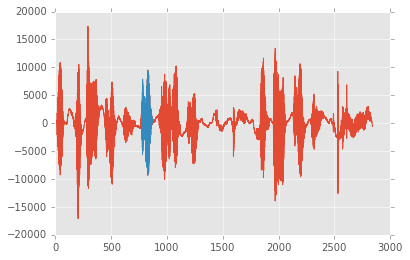

In [16]:
window = syllable_times[5][1:]
waveform2 = waveform
waveform2[:] = waveform
waveform2 = waveform2.astype('float')
waveform2[:window[0]] = np.nan
waveform2[window[1]:] = np.nan

plt.plot(t,waveform,t,waveform2)

In [17]:
# Get rasters for given unit
def get_rasters(unit,stim,before_ms=50,after_ms=100):
    s_f = unit.sampling_rate

    [syllable_times, syllables_meta] = stim.get_syllables()
    
    slbTimes = {}
    for x in syllable_times:
        slb = x[0]
        times = x[1:]
        if slb in slbTimes.keys():
            slbTimes[slb].append(times)
        else:
            slbTimes[slb] = [times]

    slbRasters = {}
    allRasters = []

    ### Conversion of sampling rate?
    waveform, meta = stim.get_waveform()
    s_f_stim = meta['stim']['sampling_rate']
    conversion_ratio = s_f/s_f_stim
    
    for slb, times in slbTimes.iteritems():
        if slb not in slbRasters.keys():
            slbRasters[slb] = []
        for t in times:
            onset_idx = stim.start+round(t[0]*conversion_ratio)  # in samples
            start_idx = onset_idx-np.int(s_f*before_ms/1000.) # in samples
            #span = t[1]-t[0] # in samples
            #rs = unit.get_raster(start_idx, span, span_is_ms=False, return_ms=True)    
            span = before_ms+after_ms # in ms
            rs = unit.get_raster(start_idx, span, span_is_ms=True, return_ms=True)    
            slbRasters[slb].append(rs)
            allRasters.append(rs)
    allRasters = np.asarray(allRasters)
    Nsyl, numTrials, Nbins = allRasters.shape
    allRasters = allRasters.reshape(Nsyl*numTrials,Nbins)
    
    return slbRasters, slbTimes, allRasters

In [18]:
slbRasters, slbTimes, allRasters = get_rasters(unit,stim,before_ms=50,after_ms=100)

In [19]:
def plot_rasters(slbRasters,binWidth=10,refTime=0):
    Ncols = len(slbRasters.keys())
    Nrows = 4
    plt.figure(figsize=(20,10),dpi=300)

    for slb, rasters in slbRasters.iteritems():
        j = 0
        for rs in rasters:
            plt.subplot(Nrows,Ncols,j*Ncols+slb+1)
            get_psth(rs,binWidth,rate_per_s=True,plot=True,refTime=refTime)
            #get_opt_bin_size(rs,plot=True,delta=5)
            if j==0:
                plt.title(slb)
            j += 1

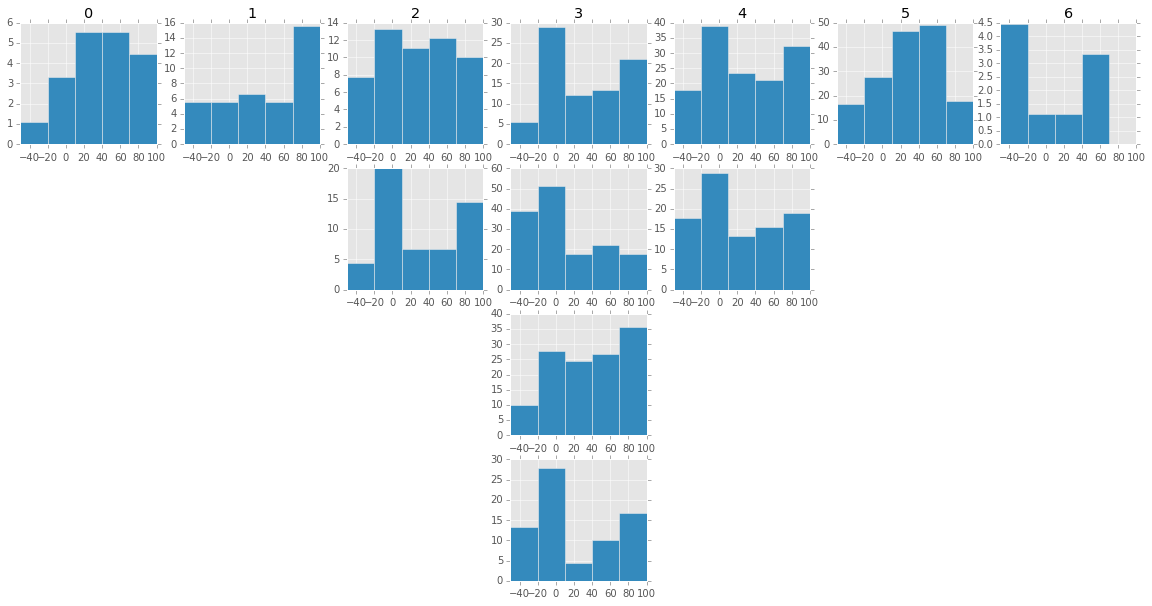

In [85]:
plot_rasters(slbRasters,binWidth=30,refTime=-50)

Decoding approaches:

1. Maximum-likelihood approach using multi-variate Gaussian distribution
2. PSTH-based decoding
3. Sparse multi-dimensional regression (Tankus et. al.)
4. Point-process models 
    
    
    

Cross-validation:

Create data structure trials with
    trials.rasters
    trials.spikeTrain
    trials.trialNum
    trials.condition
    trials.units

Generate CV folds/Divide trials into training and test set

Extract features

Train classifier (NB, LDA,...)

Decode test set using trained classifier

In [20]:
def trialize_data(kwik_file,stim):
    all_units = kwf.list_units(kwik_file)
    trials = {}
    unitID = 1
    # Loop over all units
    for one_unit in all_units:
        one_unit_clu = one_unit['clu']
        print "Trialize data from unit: %s" % one_unit
        unit = Unit(one_unit_clu, h5=kwik_file)

        subTrials = []
        # Get rasters for unit
        slbRasters, slbTimes, _ = get_rasters(unit,stim,before_ms=50,after_ms=100)
        for slb in slbRasters:
            for raster in slbRasters[slb]:
                numTrials, trialLength = raster.shape
                data = {}
                data['condition'] = slb
                data['raster'] = raster
                data['unit'] = one_unit
                #data['spikes'] = convert_to_spike_train(raster)
                subTrials.append(data)
        trials[unitID] = subTrials
        unitID += 1
    return trials

In [21]:
trials = trialize_data(kwik_file,stim)

Trialize data from unit: (0, 14, 1)
Trialize data from unit: (0, 16, 1)
Trialize data from unit: (0, 22, 1)
Trialize data from unit: (0, 4, 1)
Trialize data from unit: (0, 44, 1)
Trialize data from unit: (0, 63, 1)
Trialize data from unit: (0, 64, 1)
Trialize data from unit: (0, 66, 1)
Trialize data from unit: (0, 69, 1)
Trialize data from unit: (0, 71, 1)
Trialize data from unit: (0, 73, 1)
Trialize data from unit: (0, 75, 1)
Trialize data from unit: (0, 76, 1)
Trialize data from unit: (0, 77, 1)
Trialize data from unit: (0, 78, 1)
Trialize data from unit: (0, 79, 1)


In [22]:
def get_features(trials,binWidth=30):
    X = []
    y = []
    numUnits = len(trials.keys())
    for unitID in trials:
        trialNum = 0
        for subTrial in trials[unitID]:
            raster = subTrial['raster']
            slb = subTrial['condition']
            for rs in raster:
                psth,_ = get_psth(rs,binWidth,rate_per_s=True,plot=False,refTime=0)   
                numBins = psth.shape[0]
                if unitID==1:
                    numFeatures = numUnits*numBins
                    X.append(np.zeros(numFeatures))
                    y.append(slb)
                X[trialNum][numBins*(unitID-1):numBins*unitID] = psth
                trialNum += 1
    X = np.array(X)
    y = np.array(y)
    return X, y

In [23]:
X, y = get_features(trials, binWidth=50)
print X[0,:]

[ 20.   0.   0.   0.   0.   0.  20.   0.  20.   0.   0.   0.   0.   0.   0.
  20.  20.   0.   0.  40.   0.  20.   0.  20.   0.  20.   0.   0.  20.   0.
  20.   0.   0.   0.  20.   0.   0.   0.   0.   0.  20.   0.   0.   0.   0.
   0.   0.   0.]


In [24]:
from mpl_toolkits.mplot3d import Axes3D

def plot_features(X,y):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['b','r','g','m','gr','c']
    for j in xrange(0,6):
        ax.scatter(X[y==j,0],X[y==j,1],X[y==j,2],color=colors[j])
    plt.show()

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ldaClassifier = LinearDiscriminantAnalysis()
Xlda = ldaClassifier.fit_transform(X,y)
plot_features(X,y)
plot_features(Xlda,y)

ImportError: No module named discriminant_analysis

In [71]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def run_lda(trials,binWidth,verbose=False):
    X, y = get_features(trials,binWidth)

    K = 10
    skf = StratifiedKFold(y,K)
    acc = np.zeros(K)
    foldNum = 0
    for train, test in skf:
        if verbose:
            print "Fold %s..." % foldNum
        #print "%s %s" % (train, test)
        X_train, y_train = X[train,:], y[train]
        X_test, y_test = X[test,:], y[test]

        ldaClassifier = LinearDiscriminantAnalysis()
        #ldaClassifier = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
        ldaClassifier.fit(X_train,y_train)

        y_pred = ldaClassifier.predict(X_test)
        C = confusion_matrix(y_test, y_pred).astype(float)
        numTestTrials = len(y_test)
        acc[foldNum] = sum(np.diag(C))/numTestTrials
        foldNum += 1
    meanAcc = np.mean(acc)
    stdErr = np.std(acc)/np.sqrt(K)
    if verbose:
        print "cross-validated acc: %.2f +/- %.2f" % (np.mean(acc),np.std(acc)) 
    
    return meanAcc, stdErr

In [86]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

def run_gnb(trials,binWidth,verbose=False):
    X, y = get_features(trials,binWidth)

    K = 10
    skf = StratifiedKFold(y,K)
    acc = np.zeros(K)
    foldNum = 0
    for train, test in skf:
        if verbose:
            print "Fold %s..." % foldNum
        #print "%s %s" % (train, test)
        X_train, y_train = X[train,:], y[train]
        X_test, y_test = X[test,:], y[test]

        gnbClassifier = GaussianNB()
        gnbClassifier.fit(X_train,y_train)

        y_pred = gnbClassifier.predict(X_test)
        C = confusion_matrix(y_test, y_pred).astype(float)
        numTestTrials = len(y_test)
        acc[foldNum] = sum(np.diag(C))/numTestTrials
        foldNum += 1
    meanAcc = np.mean(acc)
    stdErr = np.std(acc)/np.sqrt(K)
    if verbose:
        print "cross-validated acc: %.2f +/- %.2f" % (np.mean(acc),np.std(acc)) 
    
    return meanAcc, stdErr

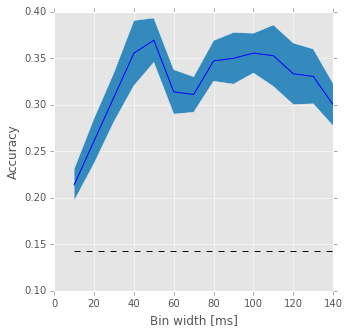

In [72]:
binWidths = np.arange(10,150,10)
N = len(binWidths)
meanAcc = np.zeros(N)
stdErr = np.zeros(N)

for n in xrange(0,N):
    meanAcc[n],stdErr[n] = run_lda(trials,binWidths[n])

chanceLevel = 1.0/7
    
plt.figure(figsize=(5,5))    
plt.plot(binWidths, meanAcc,'b')
plt.plot(binWidths,chanceLevel*np.ones(N),'--k')
plt.fill_between(binWidths,meanAcc-stdErr,meanAcc+stdErr)
plt.xlabel('Bin width [ms]')
plt.ylabel('Accuracy')
plt.show()

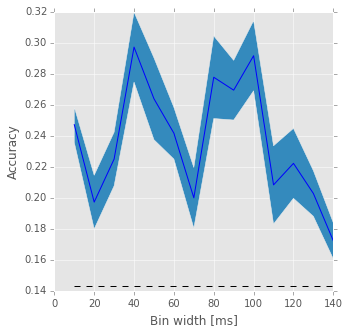

In [87]:
binWidths = np.arange(10,150,10)
N = len(binWidths)
meanAcc = np.zeros(N)
stdErr = np.zeros(N)

for n in xrange(0,N):
    meanAcc[n],stdErr[n] = run_gnb(trials,binWidths[n])

chanceLevel = 1.0/7
    
plt.figure(figsize=(5,5))    
plt.plot(binWidths, meanAcc,'b')
plt.plot(binWidths,chanceLevel*np.ones(N),'--k')
plt.fill_between(binWidths,meanAcc-stdErr,meanAcc+stdErr)
plt.xlabel('Bin width [ms]')
plt.ylabel('Accuracy')
plt.show()

In [49]:
def get_opt_bin_size(raster,min=10,max=100,delta=5,plot=False):
    Nsteps = int(round((max-min)/delta))
    binSizes = np.linspace(min,max,Nsteps)
    delta = (max-min)/Nsteps
    costFunction = np.zeros(Nsteps)
    
    numTrials = raster.shape[0]
    print "numTrials: %d" % numTrials
    for j in xrange(0,Nsteps):
        psth = get_psth(raster,binWidth=binSizes[j])
        meanRate = np.mean(psth[0])
        varRate = np.var(psth[0])
        #print "mean: %.2f var: %.2f fano: %.2f" % (meanRate,varRate,meanRate/varRate)
        costFunction[j] = (2*meanRate-varRate)/(numTrials*delta)**2
    if plot:
        plt.plot(binSizes,costFunction)
        plt.xlabel('Bin size [ms]')
        plt.ylabel('Cost function')
    return costFunction

numTrials: 30


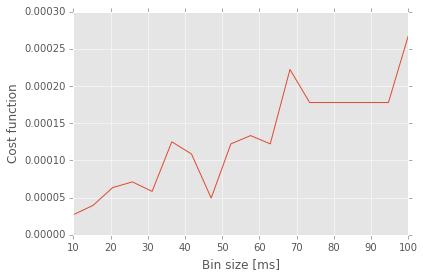

In [567]:
costFunction = lget_opt_bin_size(rs,plot=True,delta=5)